In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv
import time
%matplotlib inline

In [2]:
#Load in images
files = glob.glob("NewApples/*.jpg")

ColorImgs = []
for myFile in files:
    im = plt.imread(myFile)/255 #/255 needed to normalise the pixels value 
    ColorImgs.append(im)

In [3]:
mask_files = glob.glob("NewMasks/*.png")
masks = []
for myMask in mask_files:
    im_temp = plt.imread(myMask)
    im = im_temp[:,:,2] > 0 #convert mask from 0 and 1 to a boolean such that apple and non apple pixels can be found
    masks.append(im)

Text(0.5, 1.0, 'Mask 3')

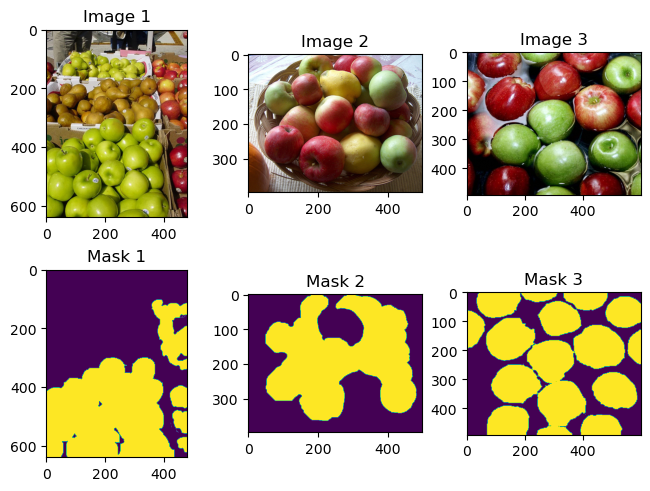

In [4]:
f, ax = plt.subplots(2, 3, constrained_layout=True)

ax[0,0].imshow(ColorImgs[0])
ax[0,0].set_title('Image 1')
ax[0,1].imshow(ColorImgs[1])
ax[0,1].set_title('Image 2')
ax[0,2].imshow(ColorImgs[7])
ax[0,2].set_title('Image 3')
ax[1,0].imshow(masks[0])
ax[1, 0].set_title('Mask 1')
ax[1,1].imshow(masks[1])
ax[1, 1].set_title('Mask 2')
ax[1,2].imshow(masks[5])
ax[1, 2].set_title('Mask 3')

In [ ]:
#Plot the images and masks
f, ax = plt.subplots(2, 3, constrained_layout=True)
for i in range(3):
    ax[0,i].imshow(ColorImgs[i])
    ax[1,i].imshow(masks[i])
    ax[0, i].set_title('Image' + str(i+1))
    ax[1, i].set_title('Mask' + str(i+1))

Plots showing the images and their associated masks. The masks are yellow for apple pixels and blue for no apple pixels.

In [5]:
#find apple and non apple pixes 
apple_pixel_1 = ColorImgs[0][masks[0]]
apple_pixel_2 = ColorImgs[1][masks[1]]
apple_pixel_3 = ColorImgs[7][masks[5]]
total_apple_pixels = np.vstack((apple_pixel_1, apple_pixel_2, apple_pixel_3))
no_apple_pixel_1 = ColorImgs[0][~masks[0]]
no_apple_pixel_2 = ColorImgs[1][~masks[1]]
no_apple_pixel_3 = ColorImgs[7][~masks[5]]
total_no_apple_pixels = np.vstack((no_apple_pixel_1,no_apple_pixel_2, no_apple_pixel_3))

In [ ]:
#find apple and non apple pixes 
apple_pixel_1 = ColorImgs[0][masks[0]]
apple_pixel_2 = ColorImgs[1][masks[1]]
apple_pixel_3 = ColorImgs[2][masks[2]]
total_apple_pixels = np.vstack((apple_pixel_1, apple_pixel_2, apple_pixel_3))
no_apple_pixel_1 = ColorImgs[0][~masks[0]]
no_apple_pixel_2 = ColorImgs[1][~masks[1]]
no_apple_pixel_3 = ColorImgs[2][~masks[2]]
total_no_apple_pixels = np.vstack((no_apple_pixel_1,no_apple_pixel_2, no_apple_pixel_3))

In [6]:
def getGaussProbNew(x,mean,cov): 

    dims = x.shape[0]
    mean = mean.reshape(-1,1)                                                             
    prob = np.exp(-.5*np.einsum('ij,ji->i',(np.transpose(x-mean) @ inv(cov)) ,x-mean))                       
    prob = prob/ np.sqrt(((2*np.pi)**dims)*det(cov))     
    return prob


In [7]:
def getMixGaussLogLike(data, mixGaussEst): 
                                                                                                                                             
    nDims, nData = data.shape                                                                                                                           
    logLike = 0;   
    curWeight = mixGaussEst['weight']  
    curMean =   mixGaussEst['mean']  
    curCov =   mixGaussEst['cov']
    k = mixGaussEst['k']
    like=np.zeros((k,data.shape[1]))
    for cluster in range(k):
        like[cluster,:] = curWeight[cluster]*getGaussProbNew(data,curMean[:,cluster],curCov[:,:,cluster])

    logLike = np.log(np.sum(like,axis=0))                                                              
                                                                                                       
    return  np.sum(logLike).item()        

In [8]:
def fitMixGauss(data, k=3, nIter=100):

    nDims, nData = data.shape
    postHidden = np.zeros(shape=(k, nData))
    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
 
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
    

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    curCov = mixGaussEst['cov']                                                                                  
    curWeight = mixGaussEst['weight']                                                                            
    curMean = mixGaussEst['mean']
   
    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cluster in range(k):

            postHidden[cluster,:] = curWeight[cluster] * getGaussProbNew(data,curMean[:,cluster],curCov[:,:,cluster])

        postHidden /= postHidden.sum(axis = 0)  
        

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            
            #update weight paramters
            mixGaussEst['weight'][cGauss] = postHidden[cGauss].sum()/postHidden.sum() 

            #update mean paramters
            mixGaussEst['mean'][:,cGauss] = data @ postHidden[cGauss] / postHidden[cGauss].sum()

            #update covariance parameters
            a = data - mixGaussEst['mean'][:,cGauss].reshape(-1,1)
            mixGaussEst['cov'][:,:,cGauss] = ((postHidden[cGauss,:] * a) @ a.T)/postHidden[cGauss].sum()
         
        log_like_list = []
        logLike = getMixGaussLogLike(data, mixGaussEst)
        log_like_list.append(logLike)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
        
    return mixGaussEst, logLike


In [9]:
k=3
mixGaussEst_apple , _ = fitMixGauss(total_apple_pixels.T)
mixGaussEst_no_apple , _= fitMixGauss(total_no_apple_pixels.T)

Log Likelihood Iter 0 : -2385339.109

Log Likelihood After Iter 0 : 293946.291

Log Likelihood After Iter 1 : 319442.632

Log Likelihood After Iter 2 : 365301.886

Log Likelihood After Iter 3 : 414192.574

Log Likelihood After Iter 4 : 459271.671

Log Likelihood After Iter 5 : 495069.957

Log Likelihood After Iter 6 : 515158.746

Log Likelihood After Iter 7 : 523637.266

Log Likelihood After Iter 8 : 528011.738

Log Likelihood After Iter 9 : 531210.778

Log Likelihood After Iter 10 : 533881.069

Log Likelihood After Iter 11 : 536113.520

Log Likelihood After Iter 12 : 537931.033

Log Likelihood After Iter 13 : 539381.687

Log Likelihood After Iter 14 : 540532.612

Log Likelihood After Iter 15 : 541453.711

Log Likelihood After Iter 16 : 542209.087

Log Likelihood After Iter 17 : 542854.237

Log Likelihood After Iter 18 : 543435.972

Log Likelihood After Iter 19 : 543993.874

Log Likelihood After Iter 20 : 544562.461

Log Likelihood After Iter 21 : 545173.463

Log Likelihood After Iter 

# Part c

In [ ]:
#Load in test images
files = glob.glob("testApples/*.jpg")
ColorImgs_test = []
for myFile in files:
    im = plt.imread(myFile)/255
    ColorImgs_test.append(im)

In [11]:
#open mask files  
mask_files = glob.glob("NewMasks/*.png")
masks_new = []
for myMask in mask_files:
    im = plt.imread(myMask)
    masks_new.append(im)

mask_image = masks_new[4]

In [ ]:
#open mask files  
mask_files = glob.glob("testApples/*.png")
masks = []
for myMask in mask_files:
    im = plt.imread(myMask)
    masks.append(im)
    break

mask_image = masks[0]

Text(0.5, 1.0, 'Mask 1')

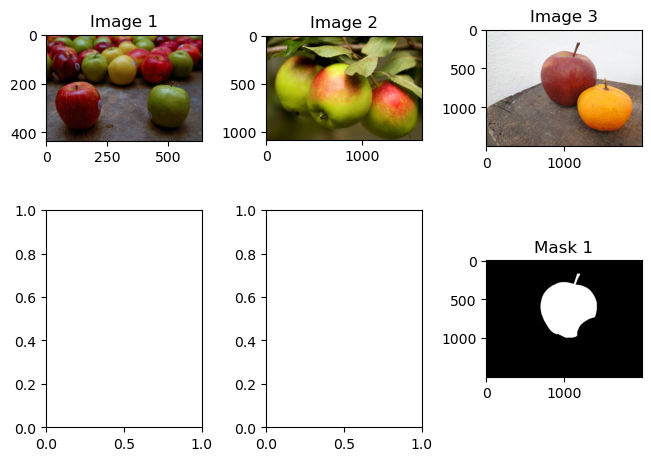

In [12]:
#plot the images and masks for tests
f, ax = plt.subplots(2, 3, constrained_layout=True)

ax[0,0].imshow(ColorImgs[2])
ax[0,0].set_title('Image 1')
ax[0,1].imshow(ColorImgs[5])
ax[0,1].set_title('Image 2')
ax[0,2].imshow(ColorImgs[6])
ax[0,2].set_title('Image 3')
ax[1,2].imshow(mask_image)
ax[1, 2].set_title('Mask 1')


In [ ]:
#plot the images and masks
f, ax = plt.subplots(2, 3, constrained_layout=True)
for i in range(3):
    ax[0,i].imshow(ColorImgs_test[i])
    ax[1,2].imshow(mask_image)
    ax[0, i].set_title('Image' + str(i+1))
    ax[1, 2].set_title('Mask')

Only image 3 has a mask hence the mask for image 1 and 2 are empty.

In [13]:
def get_posterior_probability(data):
    prior_apple = 0.3;
    prior_no_apple = 0.7;
    nData,nDim = data.shape

    post_probability_apple = np.zeros(nData)

    mean_apple = mixGaussEst_apple['mean']
    cov_apple = mixGaussEst_apple['cov']
    weight_apples = mixGaussEst_apple['weight']

    mean_no_apple = mixGaussEst_no_apple['mean']
    cov_no_apple = mixGaussEst_no_apple['cov']
    weight_no_apples = mixGaussEst_no_apple['weight']

    like_apple_pixel = np.zeros((k,nData))
    like_no_apple_pixel = np.zeros((k,nData))

    for cluster in range(k):
        like_apple_pixel[cluster,:] = weight_apples[cluster] * getGaussProbNew(data.T,mean_apple[:,cluster],cov_apple[:,:,cluster])
        like_no_apple_pixel[cluster,:] = weight_no_apples[cluster] * getGaussProbNew(data.T,mean_no_apple[:,cluster],cov_no_apple[:,:,cluster])

    probability_pixel = like_apple_pixel.sum(axis = 0) * prior_apple + like_no_apple_pixel.sum(axis = 0) * prior_no_apple
    post_probability_apple[:] = (like_apple_pixel.sum(axis = 0) * prior_apple) / (probability_pixel)

    return post_probability_apple



In [14]:
def posterior_plotter(i, i_axis):
    posterior_probabilities = []
    fig,ax = plt.subplots(1,2)
    Image = ColorImgs[i].reshape(-1,3)
    plotting_shape = ColorImgs[i].shape[:2]
    post_prob = get_posterior_probability(Image)
    ax[0].imshow(post_prob.reshape(plotting_shape))
    #posterior_probabilities.append(post_prob.reshape(plotting_shape))
    ax[0].title.set_text('posterier probability')
    ax[1].imshow(ColorImgs[i])
    ax[1].title.set_text('Test image ' + str(i_axis+1))
    plt.tight_layout()
    return post_prob.reshape(plotting_shape)

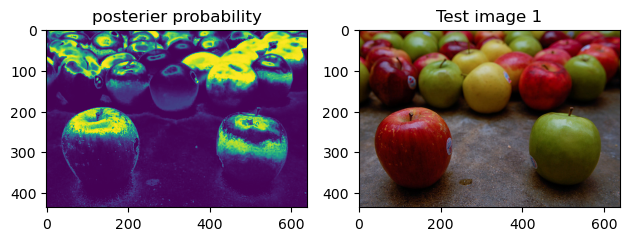

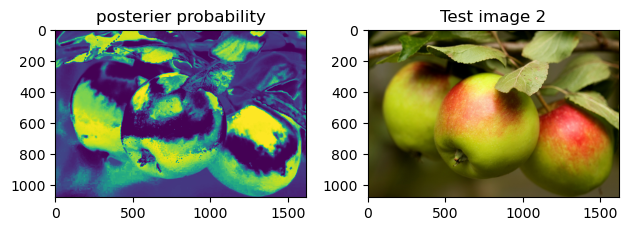

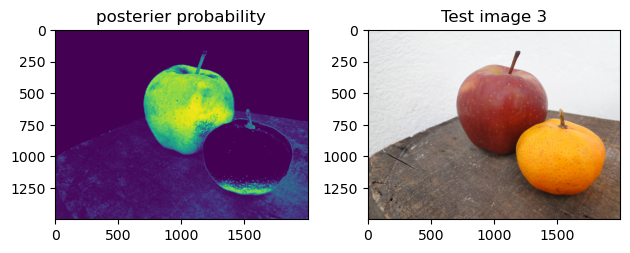

In [15]:
_ = posterior_plotter(2, 0)
_ = posterior_plotter(5, 1)
test_image_posterior = posterior_plotter(6, 2)

In [ ]:
# Plot posterier probability and the test images

posterior_probabilities = []
fig,ax = plt.subplots(3,2)

for i in range(len(ColorImgs_test)): 
    Image = ColorImgs_test[i].reshape(-1,3)
    plotting_shape = ColorImgs_test[i].shape[:2]
    post_prob = get_posterior_probability(Image)
    ax[i,0].imshow(post_prob.reshape(plotting_shape))
    posterior_probabilities.append(post_prob.reshape(plotting_shape))
    ax[i,0].title.set_text('posterier probability')
    ax[i,1].imshow(ColorImgs_test[i])
    ax[i,1].title.set_text('Test image ' + str(i+1))
plt.tight_layout()

For the 1st image the red apples at the back on the right are predicted well. However, regions of shade are predicted poorly. The green apples are also predicted poorly alongside the apples that are reflecting light. It does a good job at predicting the backround as no apple.

For image 2 regions of shade are predicted poorly, for example the areas directly below the leaves. Regions that are completely green and red are predicted well, but when there is a gradient from red to green our prediction does not perform well.

Image 3 is predicted better. No apple pixels are clearly predicted as such. The red apple is predicted well apart from regions with shade or light reflection. This image is likely predicted well as there are clear colour contrasts between the apple, orange and background, whereas the other images have stronger colour gradients.

The ROC curves will be plotted later in the notebook.

In [ ]:
#Load in the extra test images
files = glob.glob("extraTestApples/*.jpg")
ColorImgs_extra_test = []
for myFile in files:
    im = plt.imread(myFile)/255
    ColorImgs_extra_test.append(im)

In [ ]:
mask_files = glob.glob("extraTestApples/*.png")
masks = []
for myMask in mask_files:
    im = plt.imread(myMask) #we want these masks as 1 and 0 not boolean so they can be used to compare against the posterior in the ROC plot
    masks.append(im)

Now we plot the extra test images 

Text(0.5, 1.0, 'Mask 2')

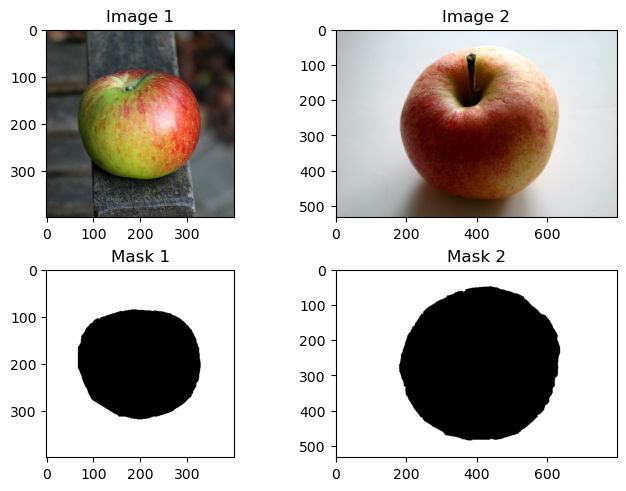

In [16]:
#plot images and masks
f, ax = plt.subplots(2, 2, constrained_layout=True)

ax[0,0].imshow(ColorImgs[3])
ax[0,0].set_title('Image 1')
ax[0,1].imshow(ColorImgs[4])
ax[0,1].set_title('Image 2')
ax[1,0].imshow(masks_new[2])
ax[1, 0].set_title('Mask 1')
ax[1,1].imshow(masks_new[3])
ax[1, 1].set_title('Mask 2')

In [ ]:
#plot images and masks
f, ax = plt.subplots(2, 2, constrained_layout=True)

ax[0,0].imshow(ColorImgs_extra_test[0])
ax[0,0].set_title('Image 1')
ax[0,1].imshow(ColorImgs_extra_test[1])
ax[0,1].set_title('Image 2')
ax[1,0].imshow(masks[0])
ax[1, 0].set_title('Mask 1')
ax[1,1].imshow(masks[1])
ax[1, 1].set_title('Mask 2')

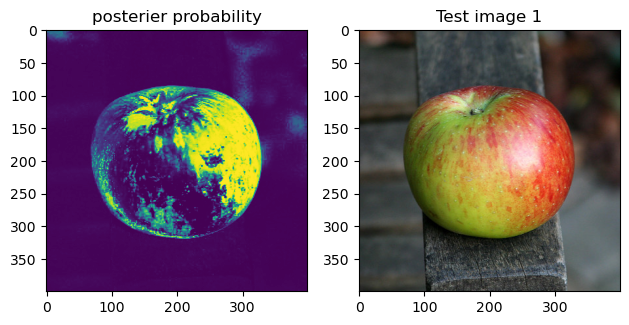

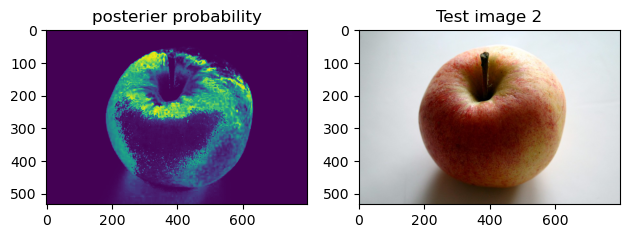

In [17]:
extra_test_1_posterior = posterior_plotter(3,0)
extra_test_2_posterior = posterior_plotter(4,1)

In [ ]:
posterior_probabilitys_extra_test = []
fig,ax = plt.subplots(2,2)

for i in range(len(ColorImgs_extra_test)): 
    Image = ColorImgs_extra_test[i].reshape(-1,3)
    plotting_shape = ColorImgs_extra_test[i].shape[:2]
    posterior_probability = get_posterior_probability(Image)
    ax[i,0].imshow(posterior_probability.reshape(plotting_shape))
    posterior_probabilitys_extra_test.append(posterior_probability.reshape(plotting_shape))
    ax[i,0].title.set_text('posterier probability')
    ax[i,1].imshow(ColorImgs_extra_test[i])
    ax[i,1].title.set_text('Extra test image ' + str(i+1))

plt.tight_layout()

For extra test image 1 the red regions are predicted strongly as apple and the green regions are predicted weakly as apple. The background is strongly predicted to be not apple. Although small parts of the backround with red pixels are weakly predicted as apple.

Extra test image 2 is predicted weakly as apple. This is likely due to regions with shade on the front and regions that are completly reflecting light, making them appear white on the image.

In [18]:
#save all posteriors and masks as their own variables to be used for ROC 
#may need to reshape
posterior_image_test = test_image_posterior 
mask_image_test = mask_image
posterior_image_extra_test_1 = extra_test_1_posterior
mask_extra_test_1 = masks_new[2]
posterior_image_extra_test_2 = extra_test_2_posterior
mask_extra_test_2 = masks_new[3]
#need to make the mask and image dimensions the same
mask_image_test = mask_image_test[:, :, 0]
mask_extra_test_1 = mask_extra_test_1[:, :, 0]
mask_extra_test_2 = mask_extra_test_2[:, :, 0]


In [ ]:
#save all posteriors and masks as their own variables to be used for ROC 
#may need to reshape
posterior_image_test = posterior_probabilities[2] 
mask_image_test = mask_image
posterior_image_extra_test_1 = posterior_probabilitys_extra_test[0] 
mask_extra_test_1 = masks[0]
posterior_image_extra_test_2 = posterior_probabilitys_extra_test[1] 
mask_extra_test_2 = masks[1]
#need to make the mask and image dimensions the same
mask_image_test = mask_image_test[:, :, 0]
mask_extra_test_1 = mask_extra_test_1[:, :, 0]
mask_extra_test_2 = mask_extra_test_2[:, :, 0]


In [19]:
#function to calculate TP, TN, FP and FN 
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr
#function to calculate the ROC
def roc(probabilities, y_test, partitions):
    roc = np.array([])
    for i in range(partitions + 1):
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

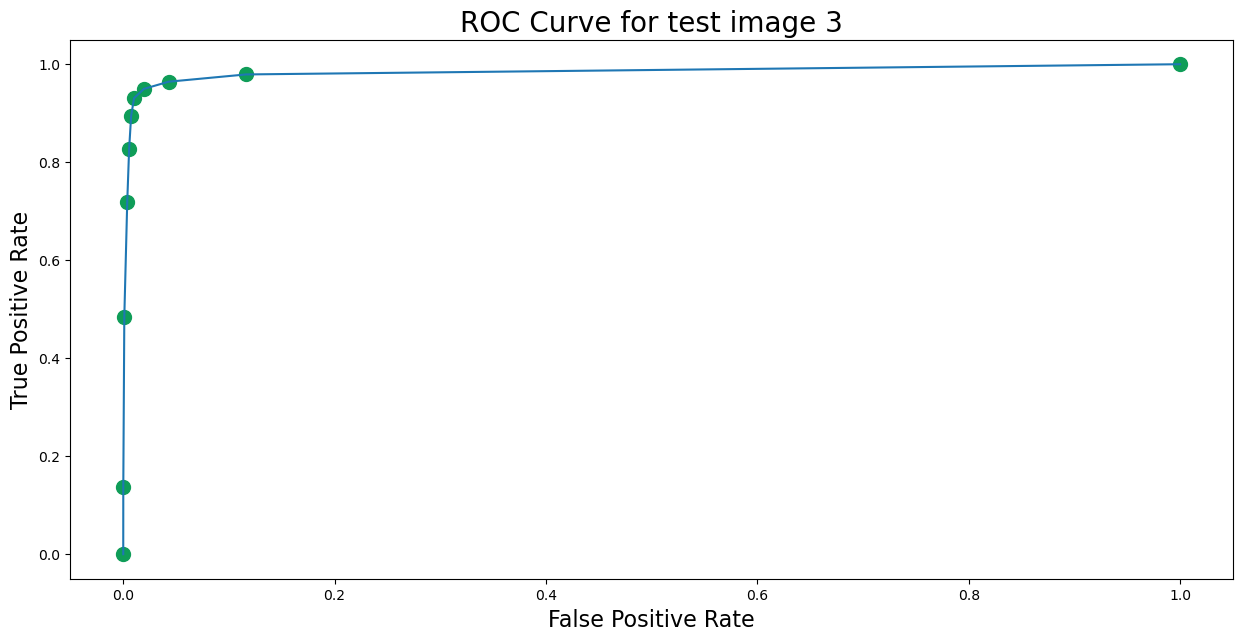

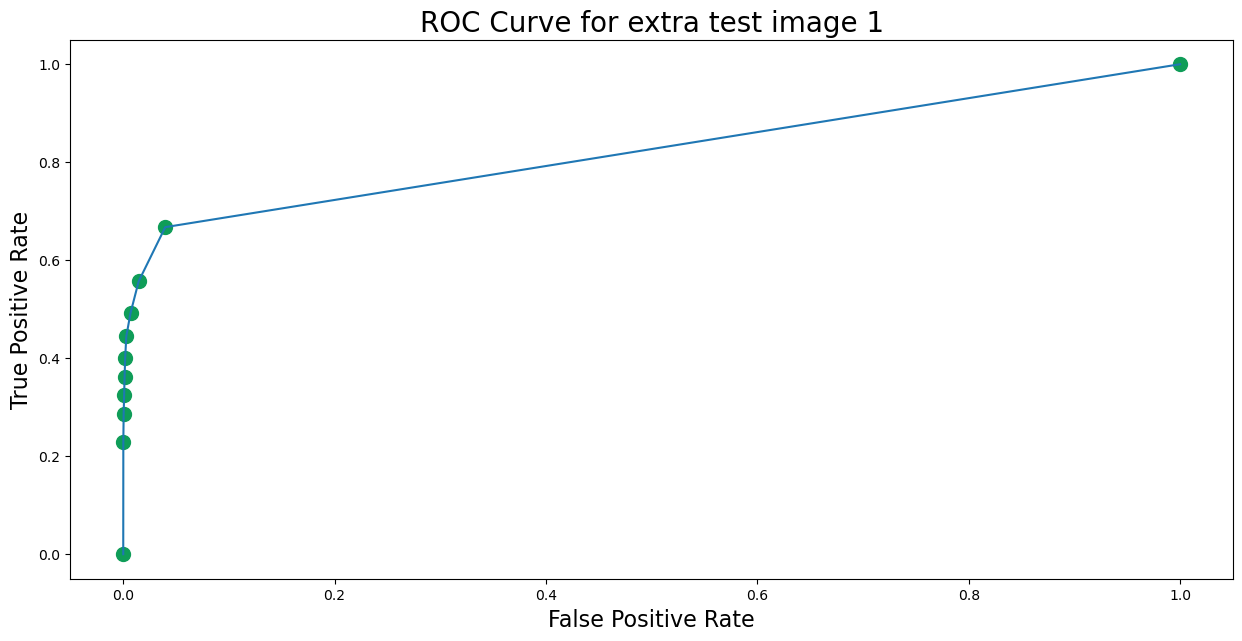

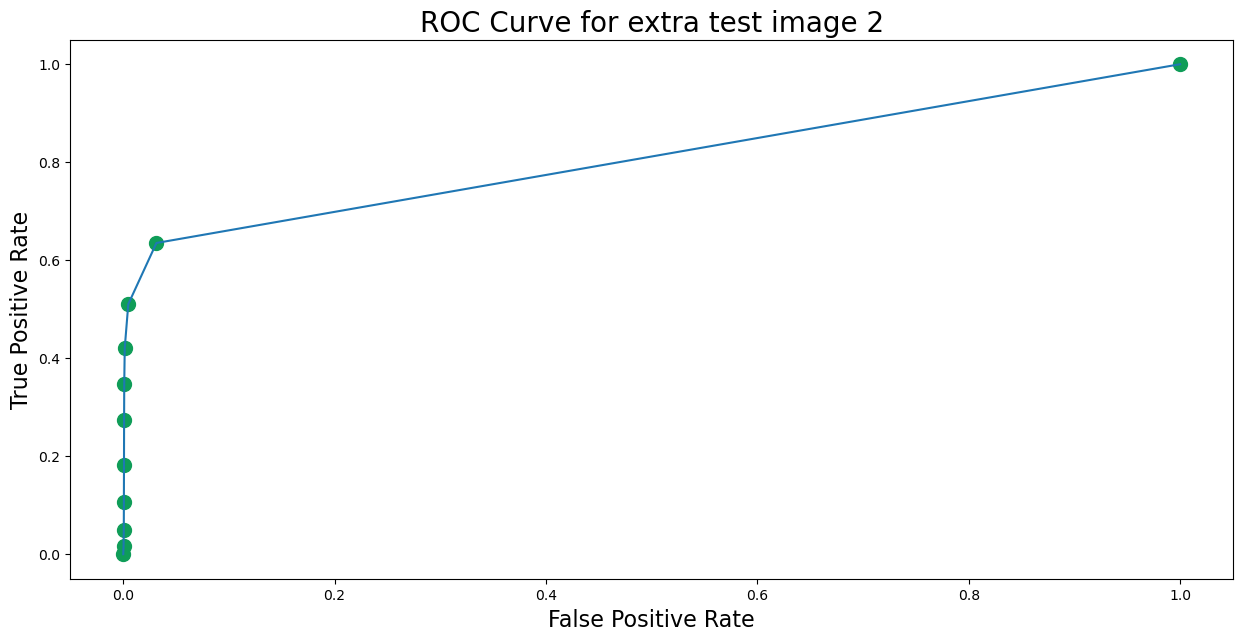

In [20]:
#functions to plot the ROC
#we have to create two seperate functions, as for the 1st test image the mask has apple pixels as black and 
#for the other two masks they are white, so we need to flip the axis when plotting the ROC
def ROC_plot_1(posterior, mask):
    plt.figure(figsize=(15,7))
    ROC = roc(posterior,mask,partitions=10)
    plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
    plt.plot(ROC[:,0],ROC[:,1])
    plt.title('ROC Curve for test image 3',fontsize=20)
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    return None

def ROC_plot_2(posterior, mask, title):
    plt.figure(figsize=(15,7))
    ROC = roc(posterior,mask,partitions=10)
    plt.scatter(ROC[:,1],ROC[:,0],color='#0F9D58',s=100)
    plt.plot(ROC[:,1],ROC[:,0])
    plt.title(title,fontsize=20)
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    return None
ROC_plot_1(posterior_image_test, mask_image_test)
ROC_plot_2(posterior_image_extra_test_1, mask_extra_test_1, 'ROC Curve for extra test image 1')
ROC_plot_2(posterior_image_extra_test_2, mask_extra_test_2, 'ROC Curve for extra test image 2')


10 equally spaced thresholds were used and we want to maximise the true possitive whilst minimising the false possitive results. The threshold that does this will be in the left uppermost point. From the ROC we clearly see a range of thresholds give varying results on the accuracy of our prediction. 

In [21]:
#functions to plot the area under the ROC curve. We cant use scipy so I will apprxoimate the integral to find the area.
def ROC_area_1(posterior, mask):
        partitions = 10
        ROC = roc(posterior,mask,partitions)
        fpr, tpr = ROC[:, 0], ROC[:, 1]
        rectangle_roc = 0
        for k in range(partitions):
                rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
        return print("AUC value: " + str(rectangle_roc))

def ROC_area_2(posterior, mask):
        partitions = 10
        ROC = roc(posterior,mask,partitions)
        fpr, tpr = ROC[:, 1], ROC[:, 0]
        rectangle_roc = 0
        for k in range(partitions):
                rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
        return print("AUC value: " + str(rectangle_roc))
print("For test image 3:")
ROC_area_1(posterior_image_test, mask_image_test)
print("For extra test image 1:")
ROC_area_2(posterior_image_extra_test_1, mask_extra_test_1)
print("For extra test image 2:")
ROC_area_2(posterior_image_extra_test_2, mask_extra_test_2)

For test image 3:
AUC value: 0.995151863600408
For extra test image 1:
AUC value: 0.9844007236037894
For extra test image 2:
AUC value: 0.9875411250053232


# Part F

The training set is taken out of the original dataset and is used to fit the model. The validation set is used to find the optimal values for the hyper-parameters of the model. The testing set is used to evaluate the performance of the model and to enables it to generalise well to new data points. The need for the training and validation set is that if we were just using the training set the final error of the model would be smaller than the actual error. This reduces the models ability to generalise.
